# Compiling Yelp Restaurant Dataset

## Overview

This notebook compiles a dataset of restaurants from Yelp business data. Then we will combine this with labor market/economic data from BLS and BEA to analyze what causes small business openings and closings.

## Getting Started
1. Download the required libraries:
    ```bash
    pip install -r requirements.txt
    ```

2. Create the `data/` directory and place the downloaded data files in the appropriate subdirectories as specified in the sources section.
    ```bash
    cd predicting-labor-market-trends
    mkdir data
    mkdir data/bea
    mkdir data/bls
    ```

## Sources

If API is not specified, data must be downloaded manually.

- *Yelp Business Dataset*: https://business.yelp.com/data/resources/open-dataset/
- *BLS LAUS*: https://www.bls.gov/lau/tables.htm#cntyaa (Download Labor force data by county, 2023 annual averages (XLSX))
- *BEA CAGDP1*: https://apps.bea.gov/regional/downloadzip.htm (Download CAGDP1 folder under GDP tab)
- *County Shapefiles*: https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip

## Directory Structure
```bash
predicting-small-business-performance/
    ├── data/
    │   ├── Yelp JSON/
    │   │   └── yelp_dataset/
    │   │       └── yelp_academic_dataset_business.json
    │   │       └── yelp_academic_dataset_review.json
    │   ├── bea/
    │   │   └── CAGDP1__ALL_AREAS_2001_2023.csv
    │   └── bls/
    │       └── laucnty23.xlsx
    │   └── cb_2018_us_county_5m/
    │       └── cb_2018_us_county_5m.shp
    │── compile_dataset.ipynb
    └── business_economic_data.csv
```

## Data Dictionary
| Column Name               | Data Type     | Description                                      | Source                     |
|---------------------------|---------------|--------------------------------------------------|----------------------------|
| FIPS5                    | String        | 5-digit FIPS code for the county where the business is located | BLS                        |
| business_id               | String        | Unique identifier for each business              | Yelp                       |
| is_open                  | Integer       | Indicates if the business is currently open (1) or closed (0) | Yelp                       |
| stars                     | Float         | Average rating of the business                   | Yelp                       |
| review_count              | Integer       | Number of reviews for the business               | Yelp                       |
| attributes               | Object        | Various attributes of the business (e.g., "Good for Kids", "Outdoor Seating") | Yelp                       |
| categories                | String        | Categories associated with the business          | Yelp                       |
| name                      | String        | Name of the business                             | Yelp                       |
| city                      | String        | City where the business is located               | Yelp                       |
| state                     | String        | State where the business is located              | Yelp                       |
| address                   | String        | Address of the business                          | Yelp                       |
| postal_code               | String        | Postal code of the business                      | Yelp                       |
| latitude                 | Float         | Latitude of the business location                | Yelp                       |
| longitude                | Float         | Longitude of the business location               | Yelp                       |
| geometry                 | Geometry      | GeoPandas geometry object for the business location, created from latitude and longitude | GeoPandas                       |
| labor_force               | Integer       | Total labor force in the county                  | BLS                        |
| employed                  | Integer       | Number of employed individuals in the county     | BLS                        |
| unemployed                | Integer       | Number of unemployed individuals in the county   | BLS                        |
| unemployment_rate        | Float         | Unemployment rate in the county                  | BLS                        |
| gdp                       | Float         | Gross Domestic Product for the county            | BEA                        |

## 1. Feature Engineering

In [1]:
import pandas as pd
import requests

YEAR = 2023

In [2]:
# 1. Loading BLS (Unemployment by County)
dtype = {
    'State FIPS Code': str,
    'County FIPS Code': str,
}

# Load each year's data and concatenate
BLS = pd.read_excel(f'./data/bls/laucnty{str(YEAR)[-2:]}.xlsx', skiprows=1, dtype=dtype)

# Create FIPS5 code - combination of State and County FIPS codes
BLS['FIPS5'] = BLS['State FIPS Code'] + BLS['County FIPS Code']

# Drop unnecessary columns and rows with missing FIPS5
BLS.drop(columns=['LAUS Code', 'County Name/State Abbreviation', 'State FIPS Code', 'County FIPS Code', 'Year'], inplace=True)
BLS.dropna(subset=['FIPS5'], inplace=True)

BLS

,Labor Force,Employed,Unemployed,Unemployment Rate (%),FIPS5
0,27741.0,27150.0,591.0,2.1,01001
1,113078.0,110639.0,2439.0,2.2,01003
2,8660.0,8315.0,345.0,4.0,01005
3,8582.0,8376.0,206.0,2.4,01007
4,26501.0,25963.0,538.0,2.0,01009
...,...,...,...,...,...
3216,18428.0,17344.0,1084.0,5.9,72145
3217,2801.0,2689.0,112.0,4.0,72147
3218,7250.0,6416.0,834.0,11.5,72149
3219,9314.0,8548.0,766.0,8.2,72151


In [3]:
# 2. Loading BEA (Real GDP by County)
dtype = {
    'GeoFIPS': str,
}

# Load BEA data
BEA = pd.read_csv('./data/bea/CAGDP1__ALL_AREAS_2001_2023.csv', dtype=dtype, encoding='latin1', skipfooter=4)
BEA = BEA.rename(columns={'GeoFIPS': 'FIPS5'})

# Remove quotes and whitespace from FIPS5 codes
BEA['FIPS5'] = BEA['FIPS5'].str.replace('"', '').str.strip()

# Drop unnecessary columns 
BEA = BEA.drop(columns=['GeoName', 'LineCode', 'Region', 'TableName', 'LineCode', 'IndustryClassification', 'Description', 'Unit'])

# Melt the DataFrame from wide to long format (initially each year is a separate column)
BEA = BEA.melt(id_vars=['FIPS5'], value_vars=[str(YEAR)], var_name='Year', value_name='GDP')
BEA = BEA[BEA['Year'] == str(YEAR)]
BEA.drop(columns=['Year'], inplace=True)

# Drop rows with missing FIPS5
BEA.dropna(subset=['FIPS5'], inplace=True)
BEA

/var/folders/zx/x6hb1_p95p33hh3235qrnlqm0000gn/T/ipykernel_94502/811601119.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  BEA = pd.read_csv('./data/bea/CAGDP1__ALL_AREAS_2001_2023.csv', dtype=dtype, encoding='latin1', skipfooter=4)


,FIPS5,GDP
0,00000,22671096000
1,00000,115.597
2,00000,27720709000
3,01000,245354674
4,01000,113.267
...,...,...
9529,97000,125.650
9530,97000,1057159025
9531,98000,4525827912
9532,98000,119.181


In [4]:
# 3. Merge Datasets into master panel
economic_df = pd.merge(BLS, BEA, on=['FIPS5'], how='left')
economic_df

,Labor Force,Employed,Unemployed,Unemployment Rate (%),FIPS5,GDP
0,27741.0,27150.0,591.0,2.1,01001,1945909
1,27741.0,27150.0,591.0,2.1,01001,110.403
2,27741.0,27150.0,591.0,2.1,01001,2452642
3,113078.0,110639.0,2439.0,2.2,01003,9435720
4,113078.0,110639.0,2439.0,2.2,01003,127.811
...,...,...,...,...,...,...
9380,18428.0,17344.0,1084.0,5.9,72145,NaN
9381,2801.0,2689.0,112.0,4.0,72147,NaN
9382,7250.0,6416.0,834.0,11.5,72149,NaN
9383,9314.0,8548.0,766.0,8.2,72151,NaN


In [5]:
print("Compiled dataset shape:", economic_df.shape)
print("Number of unique counties:", economic_df['FIPS5'].nunique())

Compiled dataset shape: (9385, 6)
Number of unique counties: 3221


In [6]:
# 4. Descriptive statistics of relevant columns
vars = ['Labor Force', 'Employed', 'Unemployed', 'Unemployment Rate (%)', 'GDP']
economic_df[vars] = economic_df[vars].apply(pd.to_numeric, errors='coerce')
economic_df[vars].describe(include='all')

,Labor Force,Employed,Unemployed,Unemployment Rate (%),GDP
count,9.385000e+03,9.385000e+03,9385.000000,9385.000000,9.244000e+03
mean,5.288523e+04,5.095182e+04,1933.410442,3.649579,5.285505e+06
std,1.734801e+05,1.663361e+05,7351.499142,1.243862,2.893182e+07
min,1.010000e+02,9.300000e+01,3.000000,1.300000,3.405100e+01
25%,4.630000e+03,4.481000e+03,170.000000,2.900000,1.188237e+02
50%,1.142900e+04,1.098500e+04,411.000000,3.500000,4.578975e+05
75%,3.180300e+04,3.072100e+04,1129.000000,4.200000,1.935246e+06
max,5.055267e+06,4.799021e+06,256246.000000,17.600000,9.619081e+08


In [7]:
print("Missing data proportions:")
economic_df[vars].isna().sum() / len(economic_df)

Missing data proportions:


Labor Force              0.000000
Employed                 0.000000
Unemployed               0.000000
Unemployment Rate (%)    0.000000
GDP                      0.015024
dtype: float64

In [8]:
from sklearn.model_selection import train_test_split
df = pd.read_json('./data/Yelp JSON/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
df = df.dropna(subset=['is_open', 'latitude', 'longitude', 'stars', 'review_count', 'attributes', 'categories'])
min_class_count = df['is_open'].value_counts().min()
df = df.groupby('is_open').apply(lambda x: x.sample(min_class_count, random_state=42)).reset_index(drop=True)
df

/var/folders/zx/x6hb1_p95p33hh3235qrnlqm0000gn/T/ipykernel_94502/3417442114.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('is_open').apply(lambda x: x.sample(min_class_count, random_state=42)).reset_index(drop=True)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,XWIJOIHpFR1JrkOIYHILlg,Chumley's Restaurant & Pub,1160 1st Ave,King of Prussia,PA,19406,40.096547,-75.415664,2.5,8,0,"{'Alcohol': ''full_bar'', 'OutdoorSeating': 'F...","Restaurants, Nightlife, Hotels, Bars, Event Pl...",None
1,RGTn5UPvZ84ScaaaaW2rxw,Forza! Pasta Bar,"664 Wye Road, Suite 190",Sherwood Park,AB,T8A 6B8,53.513143,-113.273791,4.0,6,0,"{'NoiseLevel': ''quiet'', 'RestaurantsDelivery...","Italian, Nightlife, Bars, Restaurants","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
2,ELXPbZrMesEAlOp7LYUGAw,The Village at Arrow Creek Parkway by Avenue5 ...,750 Arrowcreek Pkwy,Reno,NV,89511,39.410592,-119.758526,3.5,22,0,"{'WheelchairAccessible': 'True', 'ByAppointmen...","Home Services, Apartments, Real Estate","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."
3,1rfNEXrSkGXSd8LG27ncMA,Modell's Sporting Goods,2329 Cottman Ave,Philadelphia,PA,19149,40.047979,-75.056021,3.5,8,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Sporting Goods, Shopping, Local Flavor","{'Monday': '9:0-21:30', 'Tuesday': '9:0-21:30'..."
4,qKtkYb9lyQj_psgyg_wQlA,Francis The Duke Barber Co.,"1001 N 2nd St, Ste 7",Philadelphia,PA,19123,39.966595,-75.140059,4.5,19,0,"{'RestaurantsPriceRange2': '2', 'ByAppointment...","Barbers, Men's Clothing, Beauty & Spas, Shoppi...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58499,e6sTyJUiEJCDmqrD86-xMw,Schoenhouse and Manter,2206 21st Ave S,Nashville,TN,37209,36.129583,-86.802048,5.0,8,1,"{'BusinessAcceptsCreditCards': 'False', 'ByApp...","Real Estate Agents, Home Services, Real Estate...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."
58500,r5thRhSnNss1SabpD-varw,Value Kia,6915 Essington Ave,Philadelphia,PA,19153,39.905522,-75.224934,1.5,43,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Parts & Supplies, Auto Repair, Car Dealer...","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ..."
58501,6dXONUFQwVBEy5rjuqyatw,Small Mart,2700 Chartres St,New Orleans,LA,70116,29.963508,-90.050725,4.5,80,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Food, Grocery, Shopping, Bagels, Indian, Asian...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:30', ..."
58502,ZFF_anxwMwoSn0o4GlRDOg,sweetFrog Premium Frozen Yogurt,"175 Damonte Ranch Pkwy, Ste D",Reno,NV,89512,39.421931,-119.754476,2.5,21,1,"{'WiFi': 'u'free'', 'RestaurantsTakeOut': 'Tru...","Food, Ice Cream & Frozen Yogurt","{'Friday': '12:0-20:0', 'Saturday': '12:0-20:0..."


In [9]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326')


In [10]:
county_shapefile = gpd.read_file('./data/cb_2018_us_county_5m/cb_2018_us_county_5m.shp')
county_shapefile['FIPS5'] = county_shapefile['STATEFP'] + county_shapefile['COUNTYFP']
county_shapefile = county_shapefile.to_crs(epsg=4326)
county_shapefile = county_shapefile[['FIPS5', 'geometry']]
gdf = gpd.sjoin(gdf, county_shapefile, how='left', predicate='within')
gdf = gdf.drop(columns=['index_right'])
gdf

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,geometry,FIPS5
0,XWIJOIHpFR1JrkOIYHILlg,Chumley's Restaurant & Pub,1160 1st Ave,King of Prussia,PA,19406,40.096547,-75.415664,2.5,8,0,"{'Alcohol': ''full_bar'', 'OutdoorSeating': 'F...","Restaurants, Nightlife, Hotels, Bars, Event Pl...",None,POINT (-75.41566 40.09655),42091
1,RGTn5UPvZ84ScaaaaW2rxw,Forza! Pasta Bar,"664 Wye Road, Suite 190",Sherwood Park,AB,T8A 6B8,53.513143,-113.273791,4.0,6,0,"{'NoiseLevel': ''quiet'', 'RestaurantsDelivery...","Italian, Nightlife, Bars, Restaurants","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",POINT (-113.27379 53.51314),NaN
2,ELXPbZrMesEAlOp7LYUGAw,The Village at Arrow Creek Parkway by Avenue5 ...,750 Arrowcreek Pkwy,Reno,NV,89511,39.410592,-119.758526,3.5,22,0,"{'WheelchairAccessible': 'True', 'ByAppointmen...","Home Services, Apartments, Real Estate","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ...",POINT (-119.75853 39.41059),32031
3,1rfNEXrSkGXSd8LG27ncMA,Modell's Sporting Goods,2329 Cottman Ave,Philadelphia,PA,19149,40.047979,-75.056021,3.5,8,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Sporting Goods, Shopping, Local Flavor","{'Monday': '9:0-21:30', 'Tuesday': '9:0-21:30'...",POINT (-75.05602 40.04798),42101
4,qKtkYb9lyQj_psgyg_wQlA,Francis The Duke Barber Co.,"1001 N 2nd St, Ste 7",Philadelphia,PA,19123,39.966595,-75.140059,4.5,19,0,"{'RestaurantsPriceRange2': '2', 'ByAppointment...","Barbers, Men's Clothing, Beauty & Spas, Shoppi...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'...",POINT (-75.14006 39.9666),42101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58499,e6sTyJUiEJCDmqrD86-xMw,Schoenhouse and Manter,2206 21st Ave S,Nashville,TN,37209,36.129583,-86.802048,5.0,8,1,"{'BusinessAcceptsCreditCards': 'False', 'ByApp...","Real Estate Agents, Home Services, Real Estate...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ...",POINT (-86.80205 36.12958),47037
58500,r5thRhSnNss1SabpD-varw,Value Kia,6915 Essington Ave,Philadelphia,PA,19153,39.905522,-75.224934,1.5,43,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Parts & Supplies, Auto Repair, Car Dealer...","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",POINT (-75.22493 39.90552),42101
58501,6dXONUFQwVBEy5rjuqyatw,Small Mart,2700 Chartres St,New Orleans,LA,70116,29.963508,-90.050725,4.5,80,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Food, Grocery, Shopping, Bagels, Indian, Asian...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:30', ...",POINT (-90.05073 29.96351),22071
58502,ZFF_anxwMwoSn0o4GlRDOg,sweetFrog Premium Frozen Yogurt,"175 Damonte Ranch Pkwy, Ste D",Reno,NV,89512,39.421931,-119.754476,2.5,21,1,"{'WiFi': 'u'free'', 'RestaurantsTakeOut': 'Tru...","Food, Ice Cream & Frozen Yogurt","{'Friday': '12:0-20:0', 'Saturday': '12:0-20:0...",POINT (-119.75448 39.42193),32031


In [11]:
df = pd.merge(gdf, economic_df, on='FIPS5', how='left')
df = df.drop_duplicates(subset=['business_id'], keep='first')
df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,attributes,categories,hours,geometry,FIPS5,Labor Force,Employed,Unemployed,Unemployment Rate (%),GDP
0,XWIJOIHpFR1JrkOIYHILlg,Chumley's Restaurant & Pub,1160 1st Ave,King of Prussia,PA,19406,40.096547,-75.415664,2.5,8,...,"{'Alcohol': ''full_bar'', 'OutdoorSeating': 'F...","Restaurants, Nightlife, Hotels, Bars, Event Pl...",None,POINT (-75.41566 40.09655),42091,474525.0,460242.0,14283.0,3.0,89401864.0
3,RGTn5UPvZ84ScaaaaW2rxw,Forza! Pasta Bar,"664 Wye Road, Suite 190",Sherwood Park,AB,T8A 6B8,53.513143,-113.273791,4.0,6,...,"{'NoiseLevel': ''quiet'', 'RestaurantsDelivery...","Italian, Nightlife, Bars, Restaurants","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",POINT (-113.27379 53.51314),NaN,NaN,NaN,NaN,NaN,NaN
4,ELXPbZrMesEAlOp7LYUGAw,The Village at Arrow Creek Parkway by Avenue5 ...,750 Arrowcreek Pkwy,Reno,NV,89511,39.410592,-119.758526,3.5,22,...,"{'WheelchairAccessible': 'True', 'ByAppointmen...","Home Services, Apartments, Real Estate","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ...",POINT (-119.75853 39.41059),32031,264836.0,253239.0,11597.0,4.4,32124910.0
7,1rfNEXrSkGXSd8LG27ncMA,Modell's Sporting Goods,2329 Cottman Ave,Philadelphia,PA,19149,40.047979,-75.056021,3.5,8,...,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Sporting Goods, Shopping, Local Flavor","{'Monday': '9:0-21:30', 'Tuesday': '9:0-21:30'...",POINT (-75.05602 40.04798),42101,781326.0,747594.0,33732.0,4.3,110703184.0
10,qKtkYb9lyQj_psgyg_wQlA,Francis The Duke Barber Co.,"1001 N 2nd St, Ste 7",Philadelphia,PA,19123,39.966595,-75.140059,4.5,19,...,"{'RestaurantsPriceRange2': '2', 'ByAppointment...","Barbers, Men's Clothing, Beauty & Spas, Shoppi...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'...",POINT (-75.14006 39.9666),42101,781326.0,747594.0,33732.0,4.3,110703184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171103,e6sTyJUiEJCDmqrD86-xMw,Schoenhouse and Manter,2206 21st Ave S,Nashville,TN,37209,36.129583,-86.802048,5.0,8,...,"{'BusinessAcceptsCreditCards': 'False', 'ByApp...","Real Estate Agents, Home Services, Real Estate...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ...",POINT (-86.80205 36.12958),47037,410190.0,399310.0,10880.0,2.7,87529092.0
171106,r5thRhSnNss1SabpD-varw,Value Kia,6915 Essington Ave,Philadelphia,PA,19153,39.905522,-75.224934,1.5,43,...,{'BusinessAcceptsCreditCards': 'True'},"Auto Parts & Supplies, Auto Repair, Car Dealer...","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",POINT (-75.22493 39.90552),42101,781326.0,747594.0,33732.0,4.3,110703184.0
171109,6dXONUFQwVBEy5rjuqyatw,Small Mart,2700 Chartres St,New Orleans,LA,70116,29.963508,-90.050725,4.5,80,...,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Food, Grocery, Shopping, Bagels, Indian, Asian...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:30', ...",POINT (-90.05073 29.96351),22071,176980.0,169234.0,7746.0,4.4,23805024.0
171112,ZFF_anxwMwoSn0o4GlRDOg,sweetFrog Premium Frozen Yogurt,"175 Damonte Ranch Pkwy, Ste D",Reno,NV,89512,39.421931,-119.754476,2.5,21,...,"{'WiFi': 'u'free'', 'RestaurantsTakeOut': 'Tru...","Food, Ice Cream & Frozen Yogurt","{'Friday': '12:0-20:0', 'Saturday': '12:0-20:0...",POINT (-119.75448 39.42193),32031,264836.0,253239.0,11597.0,4.4,32124910.0


In [12]:
df = df.rename(columns={
    'Labor Force': 'labor_force',
    'Employed': 'employed',
    'Unemployed': 'unemployed',
    'Unemployment Rate (%)': 'unemployment_rate',
    'GDP': 'gdp',
})
df = df.drop(columns=['name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'geometry', 'FIPS5'])
df.dropna(subset=['labor_force', 'employed', 'unemployed', 'unemployment_rate', 'gdp'], inplace=True)
df

,business_id,stars,review_count,is_open,attributes,categories,hours,labor_force,employed,unemployed,unemployment_rate,gdp
0,XWIJOIHpFR1JrkOIYHILlg,2.5,8,0,"{'Alcohol': ''full_bar'', 'OutdoorSeating': 'F...","Restaurants, Nightlife, Hotels, Bars, Event Pl...",None,474525.0,460242.0,14283.0,3.0,89401864.0
4,ELXPbZrMesEAlOp7LYUGAw,3.5,22,0,"{'WheelchairAccessible': 'True', 'ByAppointmen...","Home Services, Apartments, Real Estate","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ...",264836.0,253239.0,11597.0,4.4,32124910.0
7,1rfNEXrSkGXSd8LG27ncMA,3.5,8,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Sporting Goods, Shopping, Local Flavor","{'Monday': '9:0-21:30', 'Tuesday': '9:0-21:30'...",781326.0,747594.0,33732.0,4.3,110703184.0
10,qKtkYb9lyQj_psgyg_wQlA,4.5,19,0,"{'RestaurantsPriceRange2': '2', 'ByAppointment...","Barbers, Men's Clothing, Beauty & Spas, Shoppi...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-18:0'...",781326.0,747594.0,33732.0,4.3,110703184.0
13,KLBWUdr0nrrK2mPBj0qg_A,4.5,56,0,"{'OutdoorSeating': 'True', 'RestaurantsPriceRa...","Restaurants, Bubble Tea, Patisserie/Cake Shop,...",{'Monday': '0:0-0:0'},208399.0,201167.0,7232.0,3.5,24410200.0
...,...,...,...,...,...,...,...,...,...,...,...,...
171103,e6sTyJUiEJCDmqrD86-xMw,5.0,8,1,"{'BusinessAcceptsCreditCards': 'False', 'ByApp...","Real Estate Agents, Home Services, Real Estate...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ...",410190.0,399310.0,10880.0,2.7,87529092.0
171106,r5thRhSnNss1SabpD-varw,1.5,43,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Parts & Supplies, Auto Repair, Car Dealer...","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",781326.0,747594.0,33732.0,4.3,110703184.0
171109,6dXONUFQwVBEy5rjuqyatw,4.5,80,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Food, Grocery, Shopping, Bagels, Indian, Asian...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:30', ...",176980.0,169234.0,7746.0,4.4,23805024.0
171112,ZFF_anxwMwoSn0o4GlRDOg,2.5,21,1,"{'WiFi': 'u'free'', 'RestaurantsTakeOut': 'Tru...","Food, Ice Cream & Frozen Yogurt","{'Friday': '12:0-20:0', 'Saturday': '12:0-20:0...",264836.0,253239.0,11597.0,4.4,32124910.0


In [13]:
df['num_categories'] = df['categories'].apply(lambda x: len(x.split(', ')) if pd.notnull(x) else 0)

df['num_attributes'] = df['attributes'].apply(lambda x: len(x) if isinstance(x, dict) else 0)

def parse_hours(hours):
    total_hours = 0
    num_days = 0
    avg_daily_hours = 0
    if isinstance(hours, dict):
        for day, time_range in hours.items():
            try:
                open_time, close_time = time_range.split('-')
                open_hour = int(open_time.split(':')[0])
                close_hour = int(close_time.split(':')[0])
                if close_hour < open_hour:
                    close_hour += 24
                total_hours += close_hour - open_hour
                num_days += 1
            except:
                continue
        if num_days > 0:
            avg_daily_hours = total_hours / num_days
    else:
        num_days = 0
        avg_daily_hours = 0
        total_hours = 0
    return pd.Series({
        'total_weekly_hours': total_hours,
        'num_days_open': num_days,
        'avg_daily_hours': avg_daily_hours
    })

df[['total_weekly_hours', 'num_days_open', 'avg_daily_hours']] = df['hours'].apply(parse_hours)
df = df.drop(columns=['categories', 'attributes', 'hours'])
df


,business_id,stars,review_count,is_open,labor_force,employed,unemployed,unemployment_rate,gdp,num_categories,num_attributes,total_weekly_hours,num_days_open,avg_daily_hours
0,XWIJOIHpFR1JrkOIYHILlg,2.5,8,0,474525.0,460242.0,14283.0,3.0,89401864.0,7,8,0.0,0.0,0.000000
4,ELXPbZrMesEAlOp7LYUGAw,3.5,22,0,264836.0,253239.0,11597.0,4.4,32124910.0,3,3,59.0,7.0,8.428571
7,1rfNEXrSkGXSd8LG27ncMA,3.5,8,0,781326.0,747594.0,33732.0,4.3,110703184.0,3,4,81.0,7.0,11.571429
10,qKtkYb9lyQj_psgyg_wQlA,4.5,19,0,781326.0,747594.0,33732.0,4.3,110703184.0,5,5,58.0,7.0,8.285714
13,KLBWUdr0nrrK2mPBj0qg_A,4.5,56,0,208399.0,201167.0,7232.0,3.5,24410200.0,9,19,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171103,e6sTyJUiEJCDmqrD86-xMw,5.0,8,1,410190.0,399310.0,10880.0,2.7,87529092.0,4,2,73.0,7.0,10.428571
171106,r5thRhSnNss1SabpD-varw,1.5,43,1,781326.0,747594.0,33732.0,4.3,110703184.0,4,1,70.0,6.0,11.666667
171109,6dXONUFQwVBEy5rjuqyatw,4.5,80,1,176980.0,169234.0,7746.0,4.4,23805024.0,8,6,51.0,7.0,7.285714
171112,ZFF_anxwMwoSn0o4GlRDOg,2.5,21,1,264836.0,253239.0,11597.0,4.4,32124910.0,2,10,24.0,3.0,8.000000


In [14]:
import pandas as pd
import json
import gzip

# Define the path to the gzipped JSONL file
file_path = 'data/Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json.gz'

# List to store selected review data
review_data = []

# Open the gzipped file and read line by line
with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for line in f:
        try:
            # Parse each line as a JSON object
            review = json.loads(line)
            # Extract only the necessary columns
            review_data.append({
                'business_id': review['business_id'],
                'stars': review['stars'],
                'useful': review['useful'],
                'text': review['text']
            })
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e} in line: {line.strip()}")
            continue

# Create a DataFrame from the extracted data
reviews = pd.DataFrame(review_data)
reviews

,business_id,stars,useful,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,3.0,0,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,Cute interior and owner (?) gave us tour of up...
...,...,...,...,...
6990275,jals67o91gcrD4DC81Vk6w,5.0,1,Latest addition to services from ICCU is Apple...
6990276,2vLksaMmSEcGbjI5gywpZA,5.0,2,"This spot offers a great, affordable east week..."
6990277,R1khUUxidqfaJmcpmGd4aw,4.0,1,This Home Depot won me over when I needed to g...
6990278,Rr9kKArrMhSLVE9a53q-aA,5.0,1,For when I'm feeling like ignoring my calorie-...


In [15]:
reviews = reviews.groupby('business_id').apply(lambda x: pd.Series({
    'weighted_avg_stars': (x['stars'] * x['useful']).sum() / x['useful'].sum() if x['useful'].sum() > 0 else x['stars'].mean(),
    'reviews': ' '.join(x['text']),
    'num_reviews': x.shape[0],
    'weighted_avg_review_length': (x['text'].apply(len) * x['useful']).sum() / x['useful'].sum() if x['useful'].sum() > 0 else x['text'].apply(len).mean()
})).reset_index()
df = pd.merge(df, reviews, on='business_id', how='left')
df.fillna({'weighted_avg_stars': 0, 'num_reviews': 0, 'weighted_avg_review_length': 0, 'reviews': ''}, inplace=True)
del reviews
df

/var/folders/zx/x6hb1_p95p33hh3235qrnlqm0000gn/T/ipykernel_94502/4259463221.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reviews = reviews.groupby('business_id').apply(lambda x: pd.Series({


,business_id,stars,review_count,is_open,labor_force,employed,unemployed,unemployment_rate,gdp,num_categories,num_attributes,total_weekly_hours,num_days_open,avg_daily_hours,weighted_avg_stars,reviews,num_reviews,weighted_avg_review_length
0,XWIJOIHpFR1JrkOIYHILlg,2.5,8,0,474525.0,460242.0,14283.0,3.0,89401864.0,7,8,0.0,0.0,0.000000,2.000000,Only pub menu was available as they were revam...,8,1307.142857
1,ELXPbZrMesEAlOp7LYUGAw,3.5,22,0,264836.0,253239.0,11597.0,4.4,32124910.0,3,3,59.0,7.0,8.428571,2.010101,We live here now. The apartment is almost perf...,23,1079.010101
2,1rfNEXrSkGXSd8LG27ncMA,3.5,8,0,781326.0,747594.0,33732.0,4.3,110703184.0,3,4,81.0,7.0,11.571429,2.250000,This review is being posted in direct response...,8,647.562500
3,qKtkYb9lyQj_psgyg_wQlA,4.5,19,0,781326.0,747594.0,33732.0,4.3,110703184.0,5,5,58.0,7.0,8.285714,3.571429,After years of getting cheap and simple buzz j...,19,891.714286
4,KLBWUdr0nrrK2mPBj0qg_A,4.5,56,0,208399.0,201167.0,7232.0,3.5,24410200.0,9,19,0.0,1.0,0.000000,4.586207,"WORST CUSTOMER SERVICE! As we walked in, no on...",56,987.534483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56302,e6sTyJUiEJCDmqrD86-xMw,5.0,8,1,410190.0,399310.0,10880.0,2.7,87529092.0,4,2,73.0,7.0,10.428571,5.000000,Lisa and Miles make the perfect dynamic duo! T...,8,417.000000
56303,r5thRhSnNss1SabpD-varw,1.5,43,1,781326.0,747594.0,33732.0,4.3,110703184.0,4,1,70.0,6.0,11.666667,1.061995,"After having car towed to Kia, car sits on lot...",45,669.973046
56304,6dXONUFQwVBEy5rjuqyatw,4.5,80,1,176980.0,169234.0,7746.0,4.4,23805024.0,8,6,51.0,7.0,7.285714,4.411215,I just returned to Chicago from a 14-day road ...,83,787.439252
56305,ZFF_anxwMwoSn0o4GlRDOg,2.5,21,1,264836.0,253239.0,11597.0,4.4,32124910.0,2,10,24.0,3.0,8.000000,2.130435,This frozen yogurt place is the best in Reno! ...,22,824.065217


In [16]:
tips = pd.read_json('./data/Yelp JSON/yelp_dataset/yelp_academic_dataset_tip.json', lines=True)
tips = tips[['business_id', 'text', 'compliment_count']]
tips

,business_id,text,compliment_count
0,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,0
1,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,0
2,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,0
3,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,0
4,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,0
...,...,...,...
908910,3lHTewuKFt5IImbXJoFeDQ,Disappointed in one of your managers.,0
908911,OaGf0Dp56ARhQwIDT90w_g,Great food and service.,0
908912,hYnMeAO77RGyTtIzUSKYzQ,Love their Cubans!!,0
908913,s2eyoTuJrcP7I_XyjdhUHQ,Great pizza great price,0


In [17]:
tips = tips.groupby('business_id').apply(
    lambda x: pd.Series({
        'tips': ' '.join(x['text']),
        'num_tips': x.shape[0],
        'weighted_avg_tip_length': (x['text'].apply(len) * (x['compliment_count'] + 1)).sum() / (x['compliment_count'] + 1).sum(),
        'compliment_count': x['compliment_count'].sum(),
        'avg_compliment_count': x['compliment_count'].mean()
    })
).reset_index()
df = pd.merge(df, tips, on='business_id', how='left')
df.fillna({'num_tips': 0, 'weighted_avg_tip_length': 0, 'tips': '', 'compliment_count': 0, 'avg_compliment_count': 0}, inplace=True)
del tips
df

/var/folders/zx/x6hb1_p95p33hh3235qrnlqm0000gn/T/ipykernel_94502/2541498594.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tips = tips.groupby('business_id').apply(


,business_id,stars,review_count,is_open,labor_force,employed,unemployed,unemployment_rate,gdp,num_categories,...,avg_daily_hours,weighted_avg_stars,reviews,num_reviews,weighted_avg_review_length,tips,num_tips,weighted_avg_tip_length,compliment_count,avg_compliment_count
0,XWIJOIHpFR1JrkOIYHILlg,2.5,8,0,474525.0,460242.0,14283.0,3.0,89401864.0,7,...,0.000000,2.000000,Only pub menu was available as they were revam...,8,1307.142857,,0.0,0.000000,0.0,0.0
1,ELXPbZrMesEAlOp7LYUGAw,3.5,22,0,264836.0,253239.0,11597.0,4.4,32124910.0,3,...,8.428571,2.010101,We live here now. The apartment is almost perf...,23,1079.010101,,0.0,0.000000,0.0,0.0
2,1rfNEXrSkGXSd8LG27ncMA,3.5,8,0,781326.0,747594.0,33732.0,4.3,110703184.0,3,...,11.571429,2.250000,This review is being posted in direct response...,8,647.562500,Looking for Phillies stuff Remember when this ...,2.0,28.500000,0.0,0.0
3,qKtkYb9lyQj_psgyg_wQlA,4.5,19,0,781326.0,747594.0,33732.0,4.3,110703184.0,5,...,8.285714,3.571429,After years of getting cheap and simple buzz j...,19,891.714286,Loving the executive shave! Will is the king o...,5.0,53.666667,1.0,0.2
4,KLBWUdr0nrrK2mPBj0qg_A,4.5,56,0,208399.0,201167.0,7232.0,3.5,24410200.0,9,...,0.000000,4.586207,"WORST CUSTOMER SERVICE! As we walked in, no on...",56,987.534483,Good egg tart,1.0,13.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56302,e6sTyJUiEJCDmqrD86-xMw,5.0,8,1,410190.0,399310.0,10880.0,2.7,87529092.0,4,...,10.428571,5.000000,Lisa and Miles make the perfect dynamic duo! T...,8,417.000000,,0.0,0.000000,0.0,0.0
56303,r5thRhSnNss1SabpD-varw,1.5,43,1,781326.0,747594.0,33732.0,4.3,110703184.0,4,...,11.666667,1.061995,"After having car towed to Kia, car sits on lot...",45,669.973046,Won't be going back Waste of several hours of ...,6.0,149.000000,0.0,0.0
56304,6dXONUFQwVBEy5rjuqyatw,4.5,80,1,176980.0,169234.0,7746.0,4.4,23805024.0,8,...,7.285714,4.411215,I just returned to Chicago from a 14-day road ...,83,787.439252,This place has banana foster rootbeer! Bagels ...,11.0,62.000000,0.0,0.0
56305,ZFF_anxwMwoSn0o4GlRDOg,2.5,21,1,264836.0,253239.0,11597.0,4.4,32124910.0,2,...,8.000000,2.130435,This frozen yogurt place is the best in Reno! ...,22,824.065217,,0.0,0.000000,0.0,0.0


In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']
# df['review_sentiment'] = df['reviews'].apply(analyze_sentiment)
df['tips_sentiment'] = df['tips'].apply(analyze_sentiment)
df

,business_id,stars,review_count,is_open,labor_force,employed,unemployed,unemployment_rate,gdp,num_categories,...,weighted_avg_stars,reviews,num_reviews,weighted_avg_review_length,tips,num_tips,weighted_avg_tip_length,compliment_count,avg_compliment_count,tips_sentiment
0,XWIJOIHpFR1JrkOIYHILlg,2.5,8,0,474525.0,460242.0,14283.0,3.0,89401864.0,7,...,2.000000,Only pub menu was available as they were revam...,8,1307.142857,,0.0,0.000000,0.0,0.0,0.0000
1,ELXPbZrMesEAlOp7LYUGAw,3.5,22,0,264836.0,253239.0,11597.0,4.4,32124910.0,3,...,2.010101,We live here now. The apartment is almost perf...,23,1079.010101,,0.0,0.000000,0.0,0.0,0.0000
2,1rfNEXrSkGXSd8LG27ncMA,3.5,8,0,781326.0,747594.0,33732.0,4.3,110703184.0,3,...,2.250000,This review is being posted in direct response...,8,647.562500,Looking for Phillies stuff Remember when this ...,2.0,28.500000,0.0,0.0,0.0000
3,qKtkYb9lyQj_psgyg_wQlA,4.5,19,0,781326.0,747594.0,33732.0,4.3,110703184.0,5,...,3.571429,After years of getting cheap and simple buzz j...,19,891.714286,Loving the executive shave! Will is the king o...,5.0,53.666667,1.0,0.2,0.9499
4,KLBWUdr0nrrK2mPBj0qg_A,4.5,56,0,208399.0,201167.0,7232.0,3.5,24410200.0,9,...,4.586207,"WORST CUSTOMER SERVICE! As we walked in, no on...",56,987.534483,Good egg tart,1.0,13.000000,0.0,0.0,0.4404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56302,e6sTyJUiEJCDmqrD86-xMw,5.0,8,1,410190.0,399310.0,10880.0,2.7,87529092.0,4,...,5.000000,Lisa and Miles make the perfect dynamic duo! T...,8,417.000000,,0.0,0.000000,0.0,0.0,0.0000
56303,r5thRhSnNss1SabpD-varw,1.5,43,1,781326.0,747594.0,33732.0,4.3,110703184.0,4,...,1.061995,"After having car towed to Kia, car sits on lot...",45,669.973046,Won't be going back Waste of several hours of ...,6.0,149.000000,0.0,0.0,-0.9519
56304,6dXONUFQwVBEy5rjuqyatw,4.5,80,1,176980.0,169234.0,7746.0,4.4,23805024.0,8,...,4.411215,I just returned to Chicago from a 14-day road ...,83,787.439252,This place has banana foster rootbeer! Bagels ...,11.0,62.000000,0.0,0.0,0.9937
56305,ZFF_anxwMwoSn0o4GlRDOg,2.5,21,1,264836.0,253239.0,11597.0,4.4,32124910.0,2,...,2.130435,This frozen yogurt place is the best in Reno! ...,22,824.065217,,0.0,0.000000,0.0,0.0,0.0000


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['is_open', 'business_id']),
    df['is_open'],
    test_size=0.2,
    random_state=42,
    stratify=df['is_open']
)

X_train, y_train

(       stars  review_count  labor_force  employed  unemployed  \
 5150     3.0            54     410190.0  399310.0     10880.0   
 2162     3.0            31     781326.0  747594.0     33732.0   
 18153    4.5            61     293302.0  283988.0      9314.0   
 20918    4.0            24     264836.0  253239.0     11597.0   
 46694    2.0            30     302961.0  292591.0     10370.0   
 ...      ...           ...          ...       ...         ...   
 27115    4.5             8     138392.0  134859.0      3533.0   
 20188    4.0            14     305681.0  294177.0     11504.0   
 27349    4.0             6     781326.0  747594.0     33732.0   
 34835    5.0             5     507381.0  493316.0     14065.0   
 27662    3.0            18     781326.0  747594.0     33732.0   
 
        unemployment_rate          gdp  num_categories  num_attributes  \
 5150                 2.7   87529092.0               2               1   
 2162                 4.3  110703184.0               7    

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    min_df=5,
    max_df=0.8,
    strip_accents='unicode',
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]{2,}\b'
)
tfidf.fit(df['tips'] + ' ' + df['reviews'])

X_train_tfidf = pd.DataFrame(tfidf.transform(X_train['tips'] + ' ' + X_train['reviews']).toarray(), index=X_train.index, columns=tfidf.get_feature_names_out())
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test['tips'] + ' ' + X_test['reviews']).toarray(), index=X_test.index, columns=tfidf.get_feature_names_out())

X_train = pd.concat([X_train.drop(columns=['tips', 'reviews']), X_train_tfidf], axis=1)
X_test = pd.concat([X_test.drop(columns=['tips', 'reviews']), X_test_tfidf], axis=1)
X_train

,stars,review_count,labor_force,employed,unemployed,unemployment_rate,gdp,num_categories,num_attributes,total_weekly_hours,...,your food,your money,your mouth,your order,your own,your time,yourself,yum,yummy,zero
5150,3.0,54,410190.0,399310.0,10880.0,2.7,87529092.0,2,1,66.0,...,0.000000,0.005554,0.0,0.0,0.000000,0.005883,0.004261,0.000000,0.000000,0.005279
2162,3.0,31,781326.0,747594.0,33732.0,4.3,110703184.0,7,17,68.0,...,0.000000,0.012856,0.0,0.0,0.000000,0.013617,0.000000,0.000000,0.010752,0.000000
18153,4.5,61,293302.0,283988.0,9314.0,3.2,17659216.0,3,18,48.0,...,0.025235,0.000000,0.0,0.0,0.000000,0.000000,0.005952,0.007590,0.025956,0.000000
20918,4.0,24,264836.0,253239.0,11597.0,4.4,32124910.0,3,19,79.0,...,0.000000,0.000000,0.0,0.0,0.010335,0.000000,0.000000,0.000000,0.035331,0.000000
46694,2.0,30,302961.0,292591.0,10370.0,3.4,34713305.0,4,1,65.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27115,4.5,8,138392.0,134859.0,3533.0,2.6,30283015.0,2,3,72.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.030486
20188,4.0,14,305681.0,294177.0,11504.0,3.8,54376189.0,3,18,50.0,...,0.000000,0.030953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27349,4.0,6,781326.0,747594.0,33732.0,4.3,110703184.0,3,2,54.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
34835,5.0,5,507381.0,493316.0,14065.0,2.8,60134522.0,8,3,40.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.049120,0.000000,0.000000,0.000000


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-0.64483236,  0.08059467, -0.09144489, ..., -0.31202151,
        -0.44065046,  0.21359472],
       [-0.64483236, -0.12808632,  1.61324376, ..., -0.31202151,
         0.59885218, -0.32320752],
       [ 0.98898073,  0.14410627, -0.62833069, ...,  0.51342463,
         2.06882548, -0.32320752],
       ...,
       [ 0.44437637, -0.35491348,  1.61324376, ..., -0.31202151,
        -0.44065046, -0.32320752],
       [ 1.5335851 , -0.36398657,  0.35496935, ..., -0.31202151,
        -0.44065046, -0.32320752],
       [-0.64483236, -0.24603644,  1.61324376, ...,  1.10593511,
        -0.44065046, -0.32320752]], shape=(45045, 5020))

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

base_model = LogisticRegression(max_iter=1000, random_state=42)
model = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Bagging Classifier Report:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Bagging Classifier Report:
Accuracy: 0.7592789912981709
F1 Score: 0.7602794234680343
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5614
           1       0.76      0.76      0.76      5648

    accuracy                           0.76     11262
   macro avg       0.76      0.76      0.76     11262
weighted avg       0.76      0.76      0.76     11262



In [23]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("XGBoost Classifier Report:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier Report:
Accuracy: 0.785206890427988
F1 Score: 0.7863640377991699
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      5614
           1       0.78      0.79      0.79      5648

    accuracy                           0.79     11262
   macro avg       0.79      0.79      0.79     11262
weighted avg       0.79      0.79      0.79     11262



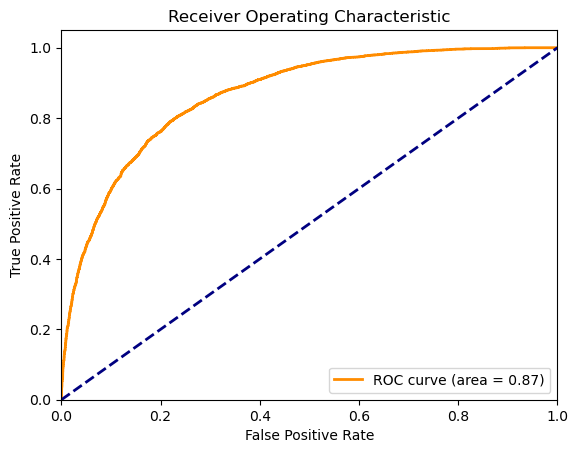

In [24]:
# Visualize ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

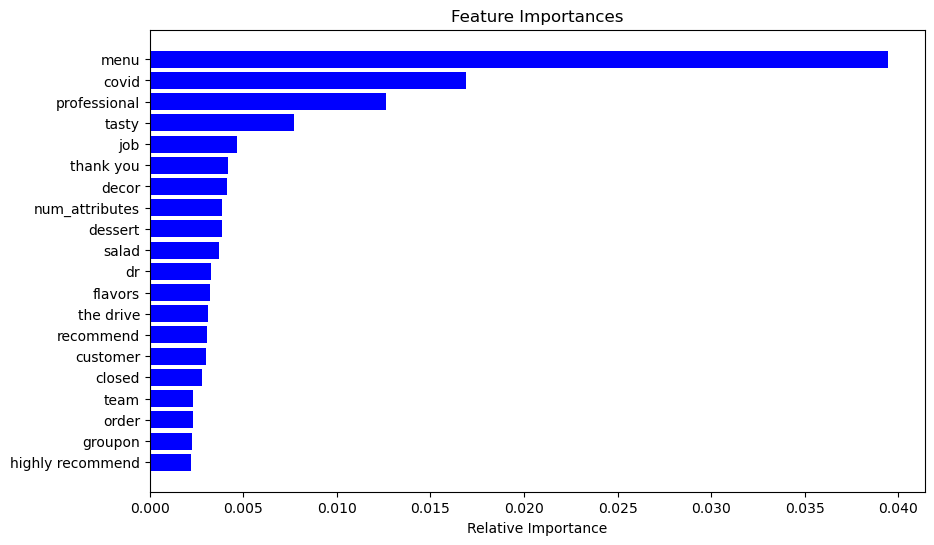

In [ ]:
# Visualize feature importance
import matplotlib.pyplot as plt
import numpy as np

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-20:] 
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()